In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import root_mean_squared_error
import pymannkendall as mk
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import seaborn as sns
sns.set_style("ticks")

import warnings
# 忽略 FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

plt.rcParams['font.family'] = "Arial"
# 保证能在Ai内编辑
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

### 定义函数

In [2]:
def calculate_error(y_true, y_pred, error_type="all"):
    """
    计算预测值和真实值之间的相关系数（R）、平均偏差误差（MBE）、
    百分比平均偏差误差（%MBE）、均方根误差（RMSE）和百分比均方根误差（%RMSE）。

    参数:
    y_true: np.array, 真实值
    y_pred: np.array, 预测值

    返回:
    dict: 包含R, MBE, %MBE, RMSE, %RMSE的字典
    """

    Uo = 5
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # 如果 y_true 或 y_pred 为值为 0 的常量向量，则在其原来的值基础上加上一个很小很小的随机值
    epsilon = 1e-10  # 定义一个很小的随机值
    if np.all(y_true == 0):
        y_true += np.random.uniform(0, epsilon, size=y_true.shape)
        y_pred = y_true
    if np.all(y_pred == 0):
        y_pred += np.random.uniform(0, epsilon, size=y_pred.shape)
        y_true = y_pred

    # 相关系数 R
    R, _ = pearsonr(y_true, y_pred)
    # 计算误差
    error = y_pred - y_true
    # 平均偏差误差（MBE）
    MBE = np.mean(error)
    # 百分比平均偏差误差（%MBE）
    MBE_percent = (MBE / np.mean(y_true)) * 100
    # 均方根误差（RMSE）
    RMSE = root_mean_squared_error(y_true, y_pred)
    # 百分比均方根误差（%RMSE）
    RMSE_percent = (RMSE / np.sqrt(np.mean(y_true**2))) * 100
    # U95
    U95 = np.sqrt(Uo**2 + MBE_percent**2 + RMSE_percent**2)

    if error_type == "R":
        return round(R, 3)
    elif error_type == "MBE":
        return round(MBE, 3)
    elif error_type == "RMSE":
        return round(RMSE, 3)
    elif error_type == "U95":
        return round(U95, 3)
    elif error_type == "all":
        return {
            "R": round(R, 3),
            # "%RMSE": RMSE_percent,
            "RMSE": round(RMSE, 3),
            # "%MBE": MBE_percent,
            "MBE": round(MBE, 3),
            "U95": round(U95, 3)
        }

    # return {
    #     "R": round(R, 3),
    #     # "%RMSE": RMSE_percent,
    #     "RMSE": round(RMSE, 3),
    #     # "%MBE": MBE_percent,
    #     "MBE": round(MBE, 3),
    #     "U95": round(U95, 3)
    # }

def get_star_string(p_value):
    if p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    else:
        return "NS"

### 数据预处理

In [3]:
# 读取数据库
database = pd.read_feather(r"D:\PhD\data\station_feather\station_data_all_v3.feather").rename(columns={'daily_radiation':'Observation', "MERRA2":"MERRA-2", "ISCCP-ITP":"ISCCP"})

# 将 date 列转换为 datetime 格式
database['date'] = pd.to_datetime(database['date'])
# 提取年份和月份
database['date'] = database['date'].dt.to_period('M')
# drop没用的字段
database = database.drop(columns=["originalID", "stationIndex", "lat", "lon"])

In [4]:
# 逐日数据
database_ISCCP_d  = database[~database['ISCCP'].isna()][['date', 'Observation','ISCCP']].rename(columns={'ISCCP':'Model'}).reset_index(drop=True)
database_GLASS_d  = database[~database['GLASS'].isna()][['date', 'Observation','GLASS']].rename(columns={'GLASS':'Model'}).reset_index(drop=True)
database_ERA5_d  = database[~database['ERA5'].isna()][['date', 'Observation','ERA5']].rename(columns={'ERA5':'Model'}).reset_index(drop=True)
database_MERRA2_d = database[['date', 'Observation','MERRA-2']].rename(columns={'MERRA-2':'Model'}).reset_index(drop=True)
database_SSP245_d = database[~database['SSP245'].isna()][['date', 'Observation','SSP245']].rename(columns={'SSP245':'Model'}).reset_index(drop=True)
database_SSP585_d = database[~database['SSP585'].isna()][['date', 'Observation','SSP585']].rename(columns={'SSP585':'Model'}).reset_index(drop=True)
del database

models_d = [database_ISCCP_d, database_GLASS_d, database_ERA5_d, database_MERRA2_d, database_SSP245_d, database_SSP585_d]

### 绘制14加法模型分解图（月尺度）

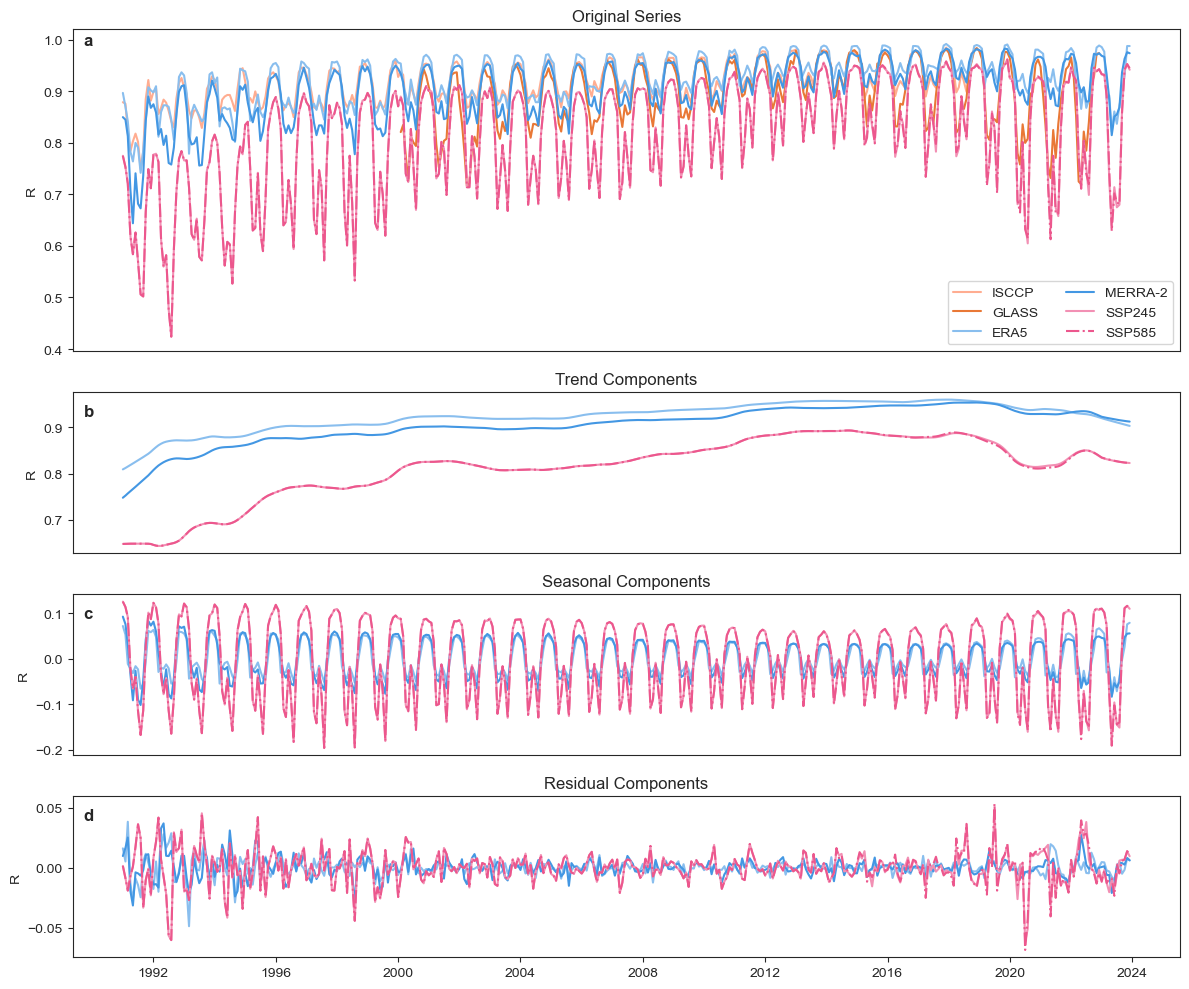

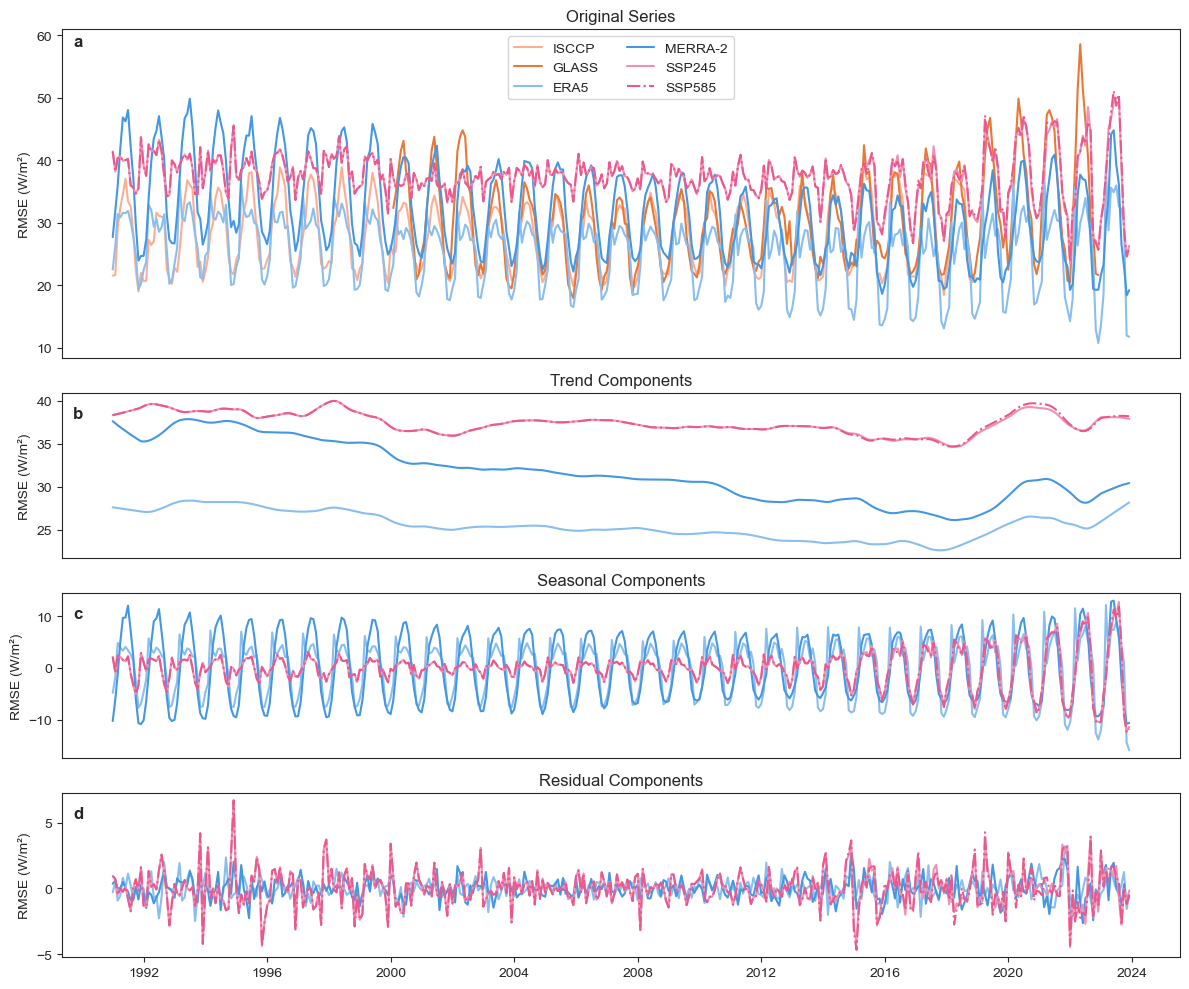

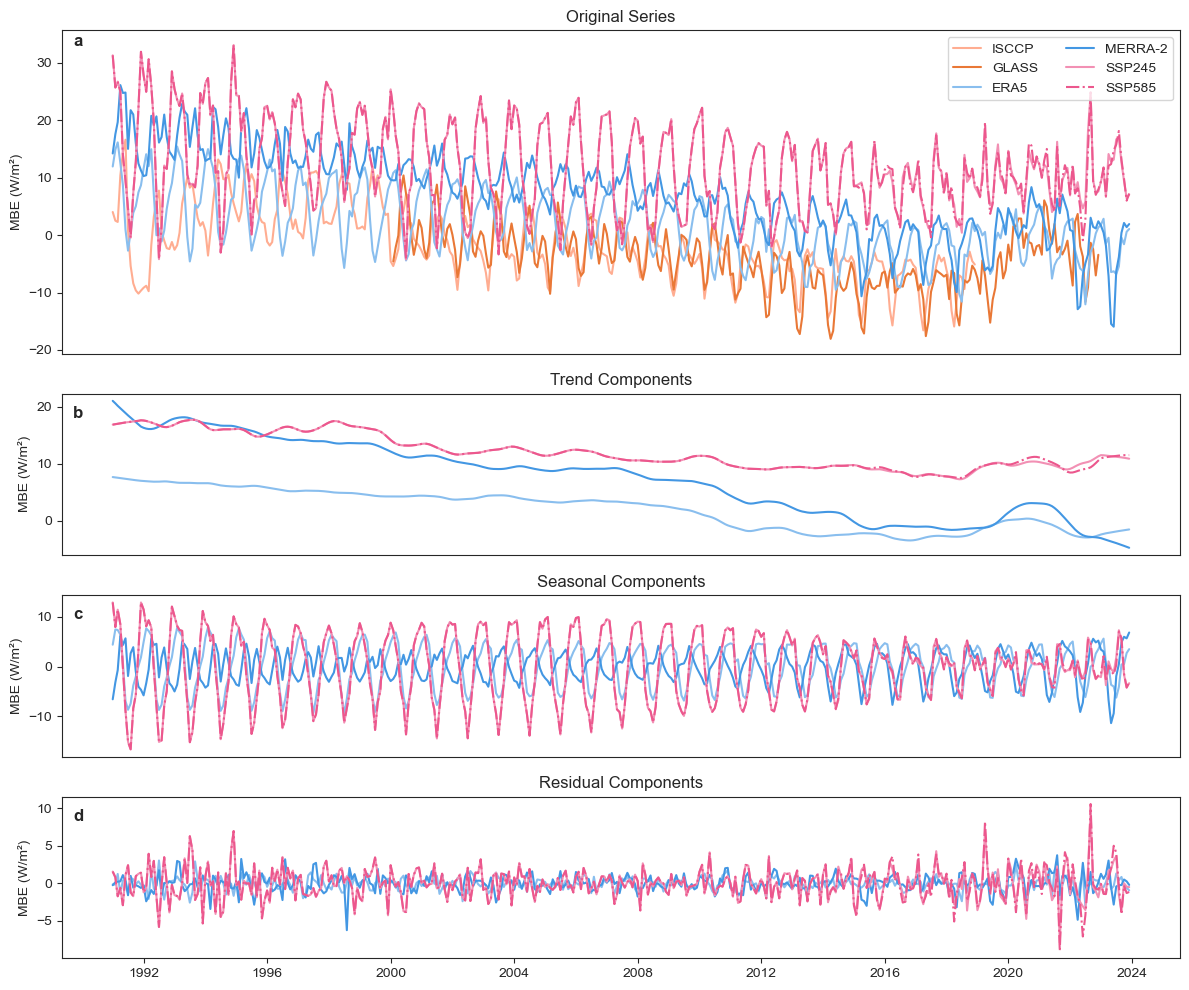

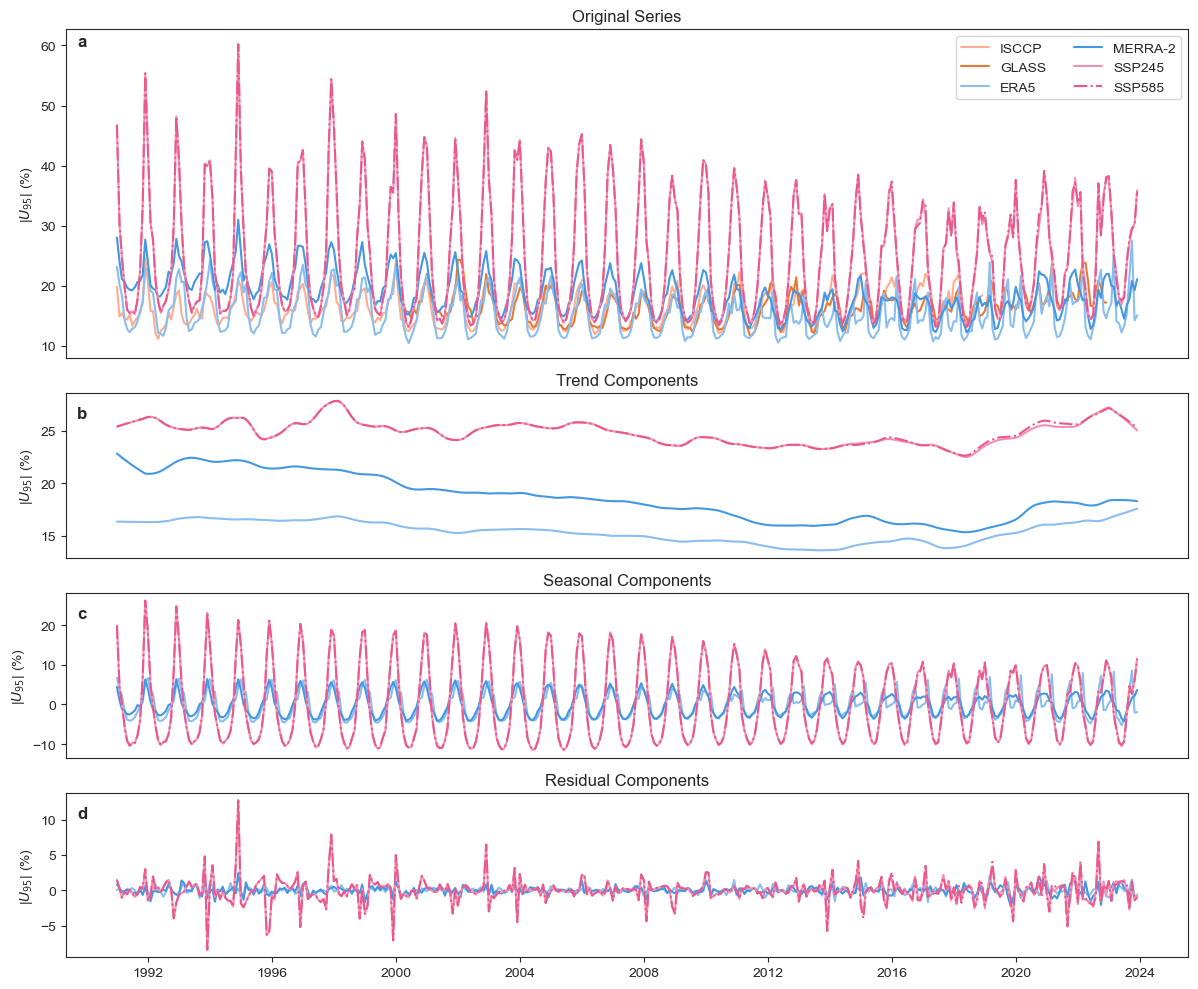

In [8]:
products_name = ['ISCCP', 'GLASS', 'ERA5', 'MERRA-2', 'SSP245', 'SSP585']
metrics = ["R", "RMSE", "MBE", "U95"]

# 遍历要计算的误差
for metric in metrics:
    # 初始化用于绘图的DataFrame
    draw_data = pd.DataFrame(columns=["date"])
    # 生成日期范围
    draw_data["date"] = pd.period_range(start='1991-01', end='2023-12', freq='M')
    # 计算指标
    for model, product_name in zip(models_d, products_name):
        # 按月份计算误差
        errorByMonth = model.groupby("date").apply(lambda x: calculate_error(x['Observation'], x['Model'], metric), include_groups=False).reset_index()
        draw_data = pd.merge(draw_data, errorByMonth, on='date', how='left').rename(columns={0:product_name})

    # 后处理数据
    draw_data.set_index("date", inplace=True)
    draw_data.index = draw_data.index.to_timestamp()
    # 根据数据绘制折线图
    products_name_part = ['ERA5', 'MERRA-2', 'SSP245', 'SSP585']
    colors = ["#ffad91", "#e97836", "#89beee", "#4397e3", "#f290b4", "#ec578d"]
    linestyles = ["-", "-", "-", "-", "-", "-."]

    # 存储不同类型的分解结果
    all_originals = []
    all_trends = []
    all_seasonals = []
    all_residuals = []

    # 遍历每一列数据
    for column in products_name:
        # 所有产品获取原始序列
        all_originals.append(draw_data[column])
        # 部分获取季节性分量
        if column in products_name_part:
            # 进行加法模型分解
            # decomposition = seasonal_decompose(draw_data[column], model='additive', period=12)
            decomposition = STL(draw_data[column], period=12).fit()

            all_trends.append(decomposition.trend)
            all_seasonals.append(decomposition.seasonal)
            all_residuals.append(decomposition.resid)

    # 将计算的时间序列保存为excel
    all_all = all_originals+all_trends+all_seasonals+all_residuals
    all_df = pd.DataFrame([series.tolist() for series in all_all])


    # 绘图
    plt.figure(figsize=(12, 10))
    if metric in ["RMSE", "MBE"]:
        metric_unit = f"{metric} (W/m²)"
    elif metric == "U95":
        metric_unit = r"|$U_{95}$| (%)"
    else:
        metric_unit = "R"
    # 创建一个 GridSpec 对象，并指定每个子图的高度比
    gs = gridspec.GridSpec(4, 1, height_ratios=[2, 1, 1, 1])

    # 使用 GridSpec 对象创建子图
    ax1 = plt.subplot(gs[0])
    for i, original in enumerate(all_originals):
        ax1.plot(original, label=products_name[i], linestyle=linestyles[i], color=colors[i])
    ax1.set_title('Original Series')
    ax1.set_ylabel(metric_unit)
    ax1.tick_params(axis='x', which='both', labelbottom=False)
    ax1.set_xticks([])
    ax1.legend(ncol=2)
    ax1.text(0.01, 0.95, 'a', transform=ax1.transAxes, fontsize=12, fontweight='bold')

    ax2 = plt.subplot(gs[1])
    for i, trend in enumerate(all_trends):
        ax2.plot(trend, label=products_name_part[i], linestyle=linestyles[i+2], color=colors[i+2])
    ax2.set_title('Trend Components')
    ax2.set_ylabel(metric_unit)
    ax2.tick_params(axis='x', which='both', labelbottom=False)
    ax2.set_xticks([])
    ax2.text(0.01, 0.85, 'b', transform=ax2.transAxes, fontsize=12, fontweight='bold')

    ax3 = plt.subplot(gs[2])
    for i, seasonal in enumerate(all_seasonals):
        ax3.plot(seasonal, label=products_name_part[i], linestyle=linestyles[i+2], color=colors[i+2])
    ax3.set_title('Seasonal Components')
    ax3.set_ylabel(metric_unit)
    ax3.tick_params(axis='x', which='both', labelbottom=False)
    ax3.set_xticks([])
    ax3.text(0.01, 0.85, 'c', transform=ax3.transAxes, fontsize=12, fontweight='bold')

    ax4 = plt.subplot(gs[3])
    for i, residual in enumerate(all_residuals):
        ax4.plot(residual, label=products_name_part[i], linestyle=linestyles[i+2], color=colors[i+2])
    ax4.set_title('Residual Components')
    ax4.set_ylabel(metric_unit)
    ax4.text(0.01, 0.85, 'd', transform=ax4.transAxes, fontsize=12, fontweight='bold')

    # 调整子图布局
    plt.tight_layout()
    all_df.to_excel(f"./datas/季节趋势分解_{metric}.xlsx", index=False)  # 保存DataFrame为Excel文件
    plt.savefig(f'figs/14加法模型分解图组4x1-{metric}.pdf', format='pdf', dpi=1000, bbox_inches='tight')
    plt.show()


### 进行MK检验（月尺度），转excel制表

In [153]:
# 遍历要计算的误差
for metric in metrics:
    # 初始化用于绘图的DataFrame
    draw_data = pd.DataFrame(columns=["date"])
    # 生成日期范围
    draw_data["date"] = pd.period_range(start='1991-01', end='2023-12', freq='M')
    # 计算指标
    for model, product_name in zip(models_d, products_name):
        # 按月份计算误差
        errorByMonth = model.groupby("date").apply(lambda x: calculate_error(x['Observation'], x['Model'], metric), include_groups=False).reset_index()
        draw_data = pd.merge(draw_data, errorByMonth, on='date', how='left').rename(columns={0:product_name})

    # 后处理数据
    draw_data.set_index("date", inplace=True)
    draw_data.index = draw_data.index.to_timestamp()
    print(f"-------------------------------{metric}----------------------------")
    results = []
    # 进行MK检验
    for product in products_name:
        filter_data = draw_data[~draw_data[product].isna()]
        result = mk.original_test(filter_data[product])
        trend = result.trend
        z = result.z
        Tau = result.Tau
        slope = result.slope
        intercept = result.intercept
        p = result.p

        results.append({
            'product': product,
            'trend': trend,
            'z': z,
            'Tau': Tau,
            'slope': slope,
            'intercept': intercept,
            'P': round(p, 3)
        })

    # 将结果转换为DataFrame并打印
    results_df = pd.DataFrame(results)
    print(results_df)


-------------------------------R----------------------------
   product       trend        z     Tau   slope  intercept       P
0    ISCCP  increasing 10.83906 0.39625 0.00021    0.88300 0.00000
1    GLASS  increasing  3.97269 0.16074 0.00018    0.88236 0.00000
2     ERA5  increasing 10.83769 0.36467 0.00021    0.88718 0.00000
3  MERRA-2  increasing 12.55967 0.42262 0.00027    0.86299 0.00000
4   SSP245  increasing 10.69556 0.35990 0.00043    0.75437 0.00000
5   SSP585  increasing 10.65191 0.35843 0.00043    0.75442 0.00000
-------------------------------RMSE----------------------------
   product       trend        z      Tau    slope  intercept       P
0    ISCCP    no trend  0.36597  0.01340  0.00105   28.22147 0.71400
1    GLASS    no trend  1.76548  0.07145  0.00995   28.41651 0.07700
2     ERA5  decreasing -4.11861 -0.13860 -0.00986   28.77070 0.00000
3  MERRA-2  decreasing -8.64911 -0.29105 -0.02739   36.71962 0.00000
4   SSP245  decreasing -4.11481 -0.13847 -0.00699   38.89604 

### 绘制15 MK检验折线图（年分组）

In [5]:
# 提取年份
models_y = models_d.copy()
for model in models_y:
    model["date"] = model["date"].apply(lambda x: x.year)

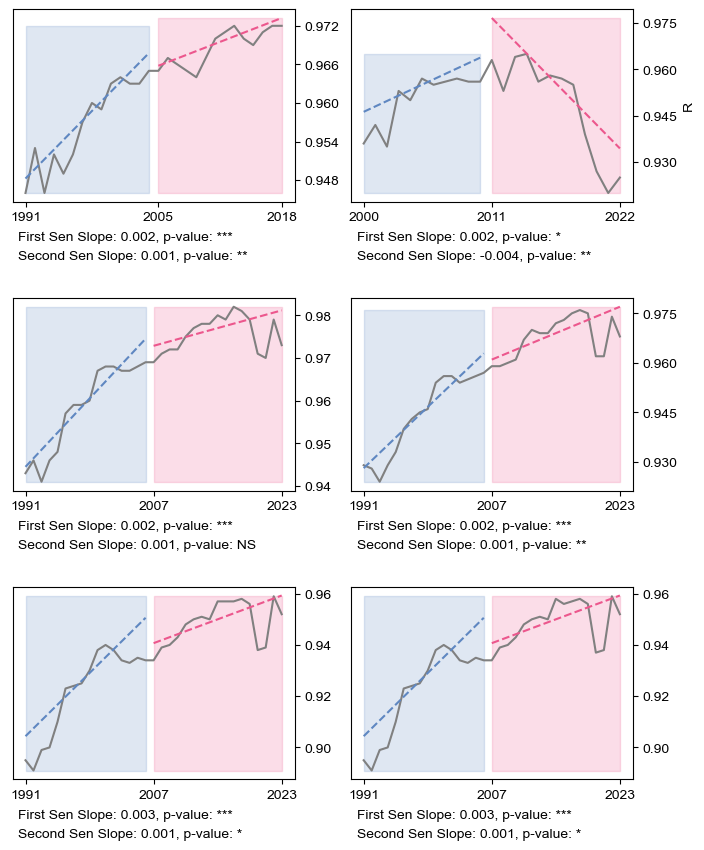

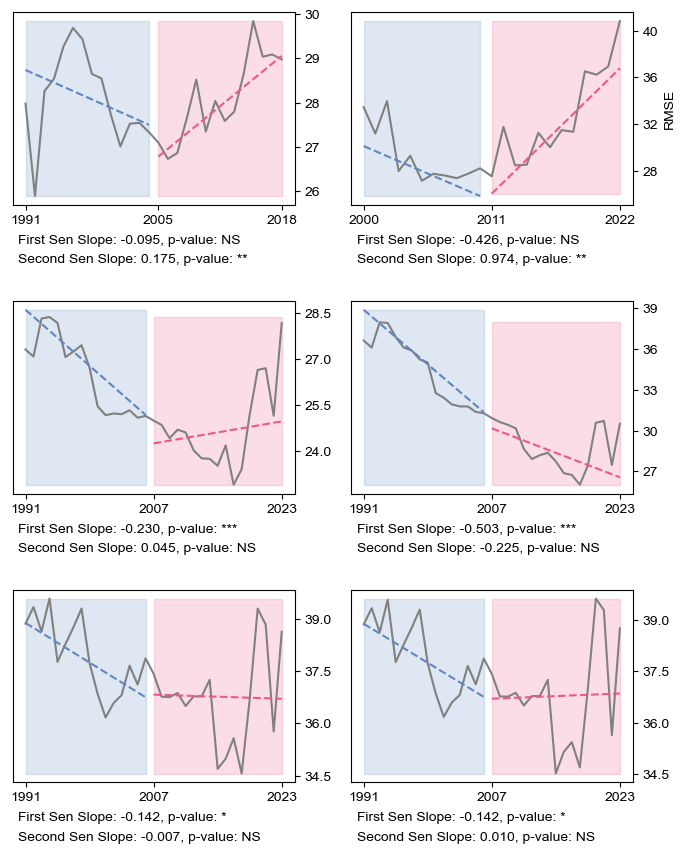

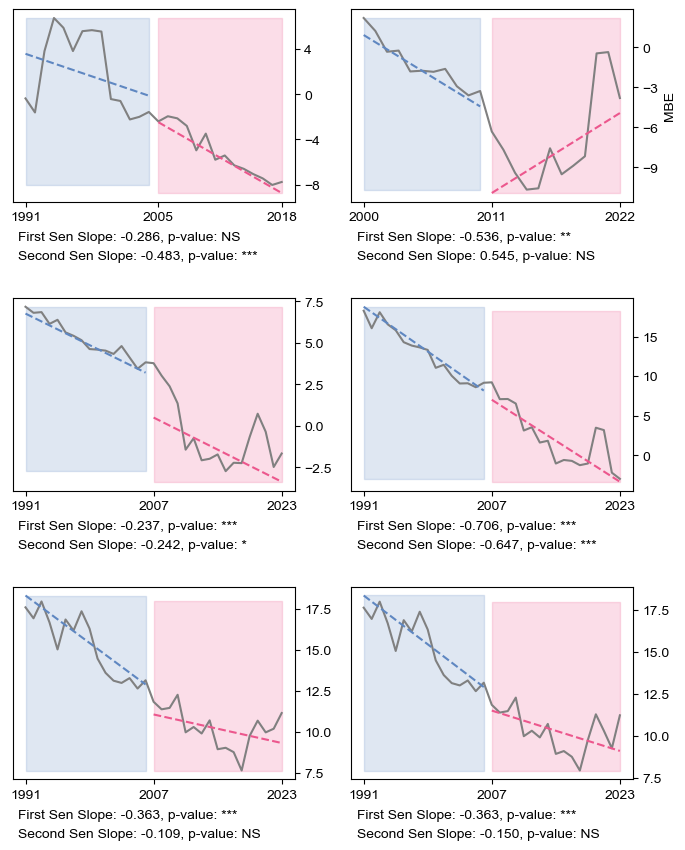

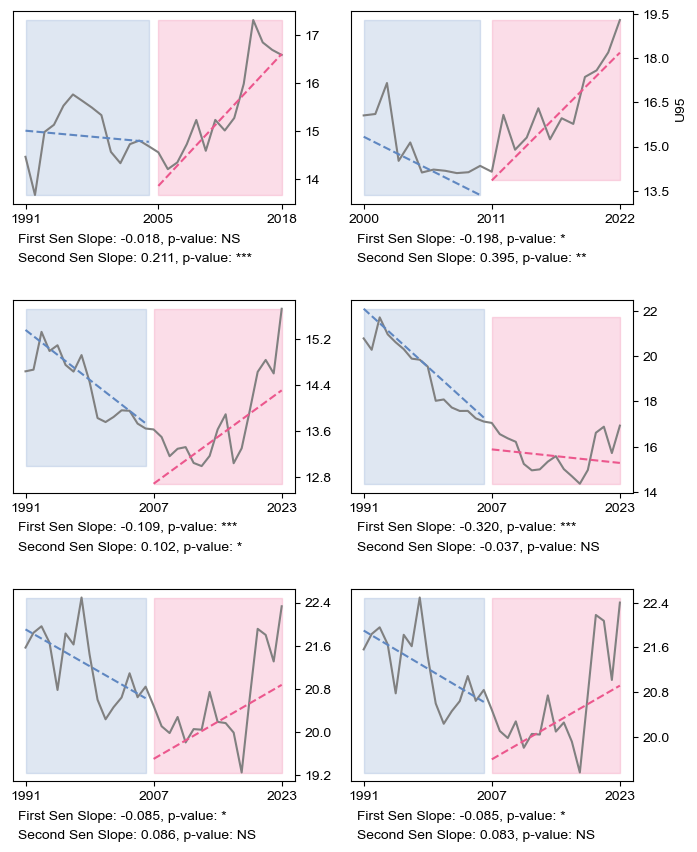

In [14]:
products_name = ['ISCCP', 'GLASS', 'ERA5', 'MERRA-2', 'SSP245', 'SSP585']
metrics = ["R", "RMSE", "MBE", "U95"]

# 遍历要计算的误差
for metric in metrics:
    fig, axs = plt.subplots(3, 2, figsize=(8, 10))
    # 计算指标
    for model, product_name, ax in zip(models_y, products_name, axs.flatten()):
        # 按年分组计算误差的时间序列
        errorByMonth = model.groupby("date").apply(lambda x: calculate_error(x['Observation'], x['Model'], metric), include_groups=False).reset_index()

        # 从时间序列中间分段
        mid_point = len(errorByMonth) // 2

        # 第一段数据
        first_segment = errorByMonth[0][:mid_point]
        # 对第一段数据进行 MK 检验
        first_result = mk.original_test(first_segment)
        first_sen_slope = first_result.slope
        first_mk_p_value = first_result.p
        first_intercept = first_result.intercept


        # 计算第一段趋势线
        first_x = np.arange(len(first_segment))
        first_trend_line = first_sen_slope * first_x + first_intercept

        # 第二段数据
        second_segment = errorByMonth[0][mid_point:]
        # 对第二段数据进行 MK 检验
        second_result = mk.original_test(second_segment)
        second_sen_slope = second_result.slope
        second_mk_p_value = second_result.p
        second_intercept = second_result.intercept

        # 计算第二段趋势线
        second_x = np.arange(len(second_segment))
        second_trend_line = second_sen_slope * second_x + second_intercept

        # 可视化绘图
        ax.plot(errorByMonth["date"], errorByMonth[0], label=product_name, color="grey", zorder=10)
        ax.plot(errorByMonth["date"][:mid_point], first_trend_line, label='First Segment Trend Line', linestyle='--', color='#5f87c1', zorder=11)
        ax.plot(errorByMonth["date"][mid_point:], second_trend_line, label='Second Segment Trend Line', linestyle='--', color='#ec578d', zorder=11)
        # 填充阶段 1 和阶段 2 的范围
        ax.fill_between(errorByMonth["date"][:mid_point], min([errorByMonth[0].min(), first_trend_line.min()]), max([errorByMonth[0].max(), first_trend_line.max()]), color='#5f87c1', alpha=0.2, zorder=9)
        ax.fill_between(errorByMonth["date"][mid_point:], min([errorByMonth[0].min(), second_trend_line.min()]), max([errorByMonth[0].max(), second_trend_line.max()]), color='#ec578d', alpha=0.2, zorder=9)



        # 标注两段的 Sen 斜率和 MK 检验结果
        ax.text(0.02,-0.2, f'First Sen Slope: {first_sen_slope:.3f}, p-value: {get_star_string(first_mk_p_value)}', transform=ax.transAxes)
        ax.text(0.02,-0.3, f'Second Sen Slope: {second_sen_slope:.3f}, p-value: {get_star_string(second_mk_p_value)}', transform=ax.transAxes)

        # 设置 轴刻度和标签
        first_date = errorByMonth["date"].iloc[0]
        mid_date = errorByMonth["date"].iloc[mid_point]
        last_date = errorByMonth["date"].iloc[-1]
        ax.set_xticks([first_date, mid_date, last_date])
        ax.set_xticklabels([first_date, mid_date, last_date])
        # 固定每个子图的Y轴刻度以及标签的个数为5个值
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
        # 将Y轴的轴刻度和轴标签设置在图像右侧
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")

        if product_name == "GLASS":
            ax.set_ylabel(metric)

        # ax.legend()

    # 调整子图之间的上下间距
    plt.subplots_adjust(hspace=0.5)  # 可以根据需要调整 hspace 的值
    # 保存为矢量
    plt.savefig(f'figs/14MK分段折线图-{metric}.pdf', format='pdf', dpi=1000, bbox_inches='tight')
    plt.show()

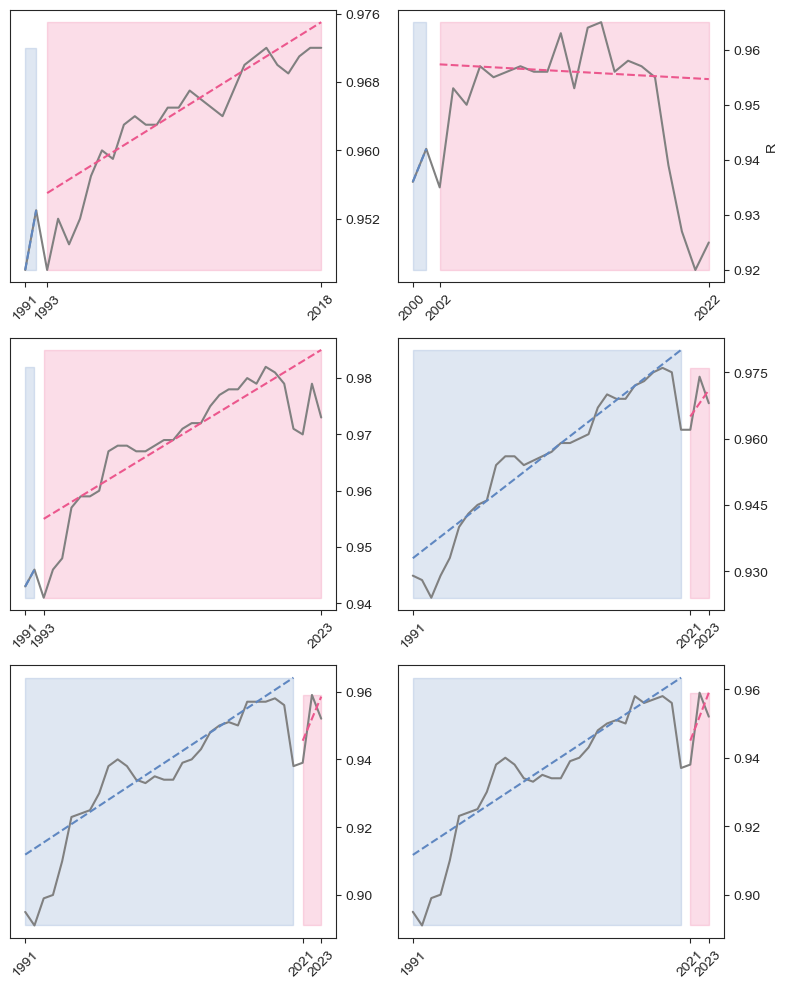

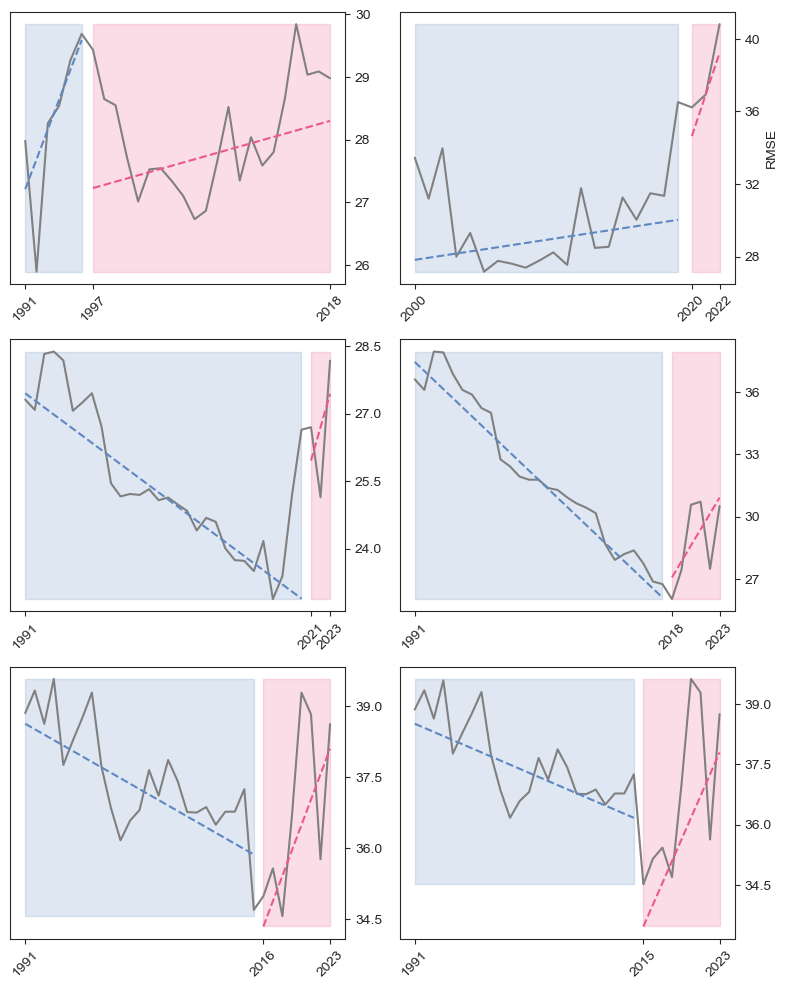

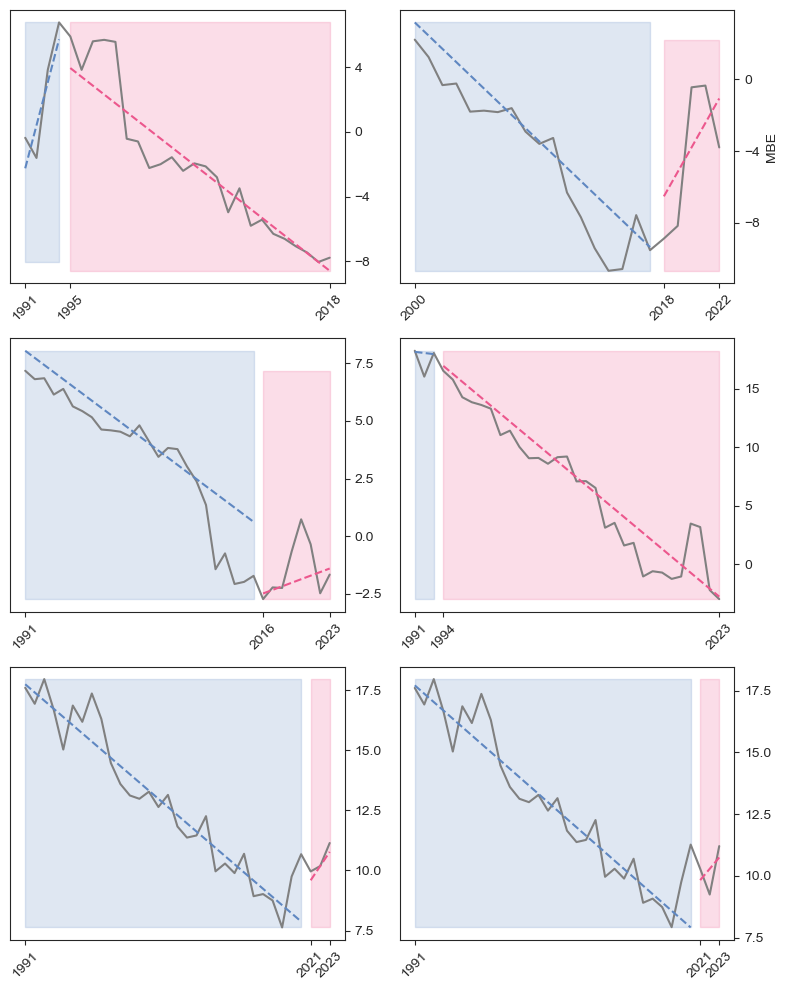

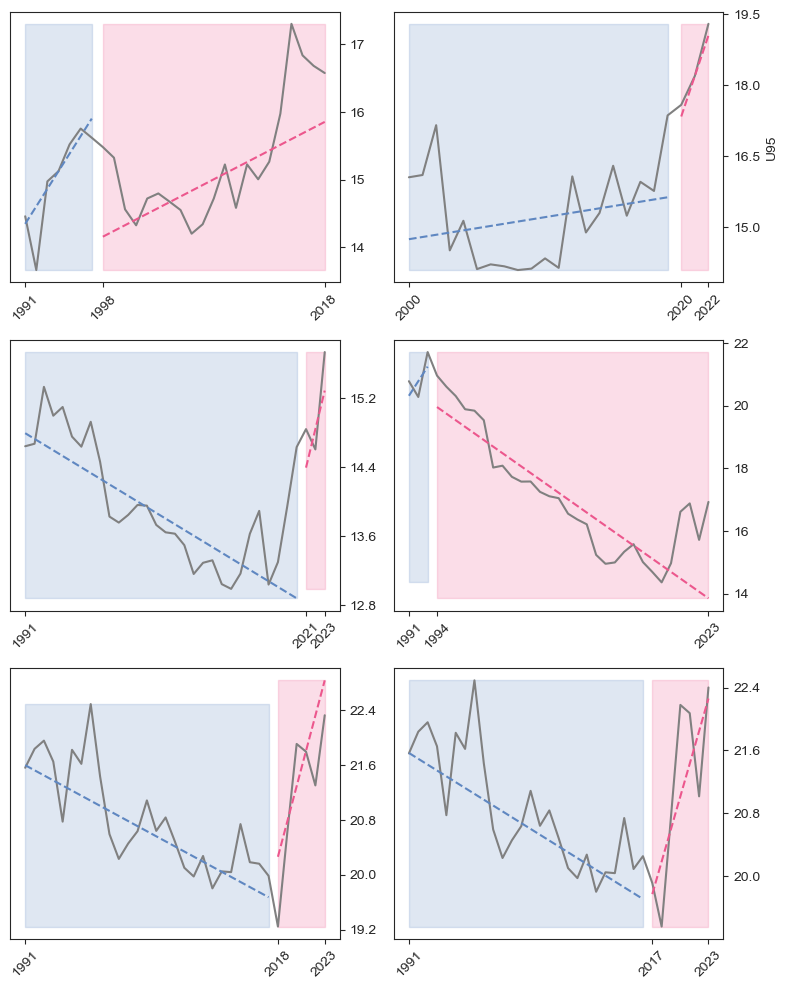

In [20]:
# 假设以下变量已定义
products_name = ['ISCCP', 'GLASS', 'ERA5', 'MERRA-2', 'SSP245', 'SSP585']
metrics = ["R", "RMSE", "MBE", "U95"]

# 定义一个函数来计算最大斜率的分割点
def find_best_segment_point(error_series):
    best_slope_sum = -np.inf
    best_point = len(error_series) // 2  # 初始值

    # 遍历可能的分割点
    for split_point in range(2, len(error_series)-2):  # 避免边界
        first_segment = error_series[:split_point]
        second_segment = error_series[split_point:]

        # 计算两段的 Sen 斜率
        first_result = mk.original_test(first_segment)
        second_result = mk.original_test(second_segment)

        # 计算斜率之和
        slope_sum = first_result.slope + second_result.slope

        # 选择斜率之和最大的分割点
        if slope_sum > best_slope_sum:
            best_slope_sum = slope_sum
            best_point = split_point

    return best_point

# 遍历要计算的误差
for metric in metrics:
    fig, axs = plt.subplots(3, 2, figsize=(8, 10))
    axs = axs.flatten()

    for ax_idx, (model, product_name) in enumerate(zip(models_y, products_name)):
        if ax_idx >= len(axs):
            break  # 超出子图数量时跳过

        ax = axs[ax_idx]

        # 按年分组计算误差的时间序列
        errorByMonth = model.groupby("date").apply(lambda x: calculate_error(x['Observation'], x['Model'], metric), include_groups=False).reset_index()

        # 动态寻找最佳分割点
        best_split_point = find_best_segment_point(errorByMonth[0])

        # 第一段数据
        first_segment = errorByMonth[0][:best_split_point]
        first_result = mk.original_test(first_segment)
        first_sen_slope = first_result.slope
        first_mk_p_value = first_result.p
        first_intercept = first_result.intercept

        # 第二段数据
        second_segment = errorByMonth[0][best_split_point:]
        second_result = mk.original_test(second_segment)
        second_sen_slope = second_result.slope
        second_mk_p_value = second_result.p
        second_intercept = second_result.intercept

        # 计算趋势线
        first_x = np.arange(len(first_segment))
        first_trend_line = first_sen_slope * first_x + first_intercept

        second_x = np.arange(len(second_segment))
        second_trend_line = second_sen_slope * second_x + second_intercept

        # 绘图
        ax.plot(errorByMonth["date"], errorByMonth[0], label=product_name, color="grey", zorder=10)
        ax.plot(errorByMonth["date"][:best_split_point], first_trend_line, label='First Segment Trend Line', linestyle='--', color='#5f87c1', zorder=11)
        ax.plot(errorByMonth["date"][best_split_point:], second_trend_line, label='Second Segment Trend Line', linestyle='--', color='#ec578d', zorder=11)

        # 填充区域
        ax.fill_between(errorByMonth["date"][:best_split_point], min(errorByMonth[0].min(), first_trend_line.min()), max(errorByMonth[0].max(), first_trend_line.max()), color='#5f87c1', alpha=0.2, zorder=9)
        ax.fill_between(errorByMonth["date"][best_split_point:], min(errorByMonth[0].min(), second_trend_line.min()), max(errorByMonth[0].max(), second_trend_line.max()), color='#ec578d', alpha=0.2, zorder=9)

        # 添加标签
        # ax.text(0.02, -0.1, f'First Sen Slope: {first_sen_slope:.3f}, p-value: {get_star_string(first_mk_p_value)}', transform=ax.transAxes)
        # ax.text(0.02, -0.2, f'Second Sen Slope: {second_sen_slope:.3f}, p-value: {get_star_string(second_mk_p_value)}', transform=ax.transAxes)

        # 设置轴刻度和标签
        first_date = errorByMonth["date"].iloc[0]
        mid_date = errorByMonth["date"].iloc[best_split_point]
        last_date = errorByMonth["date"].iloc[-1]
        ax.set_xticks([first_date, mid_date, last_date])
        ax.set_xticklabels([first_date, mid_date, last_date], rotation=45)

        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")

        if product_name == "GLASS":
            ax.set_ylabel(metric)

    # 调整布局
    plt.subplots_adjust(hspace=0.5)
    plt.tight_layout()
    plt.show()

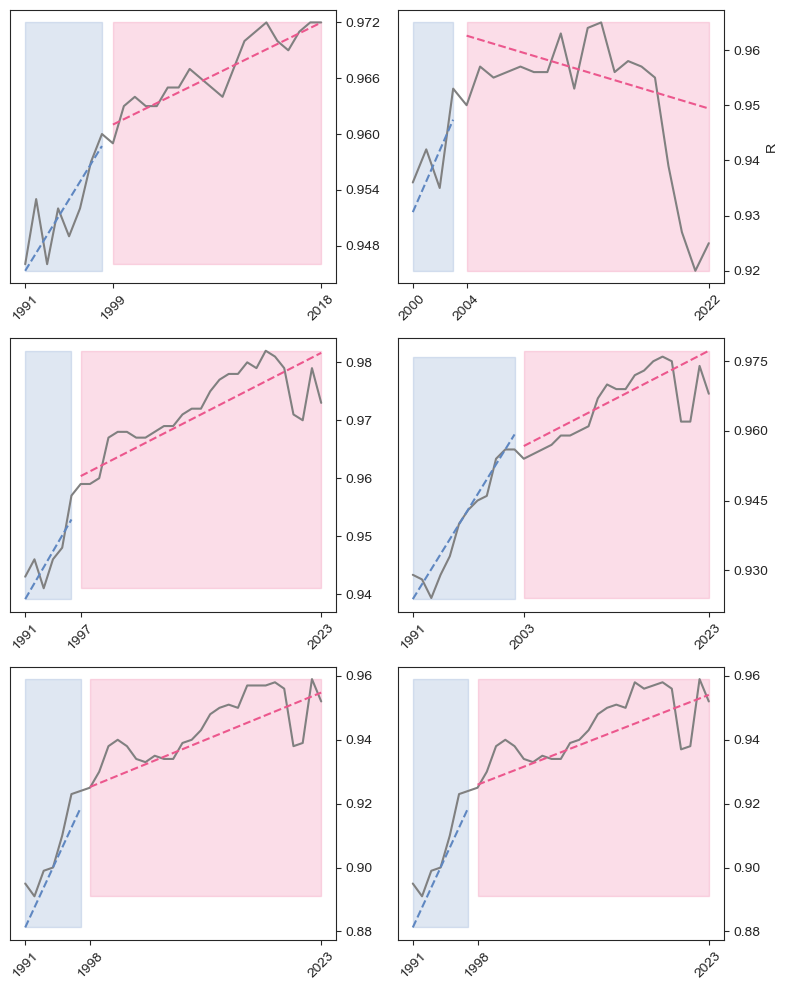

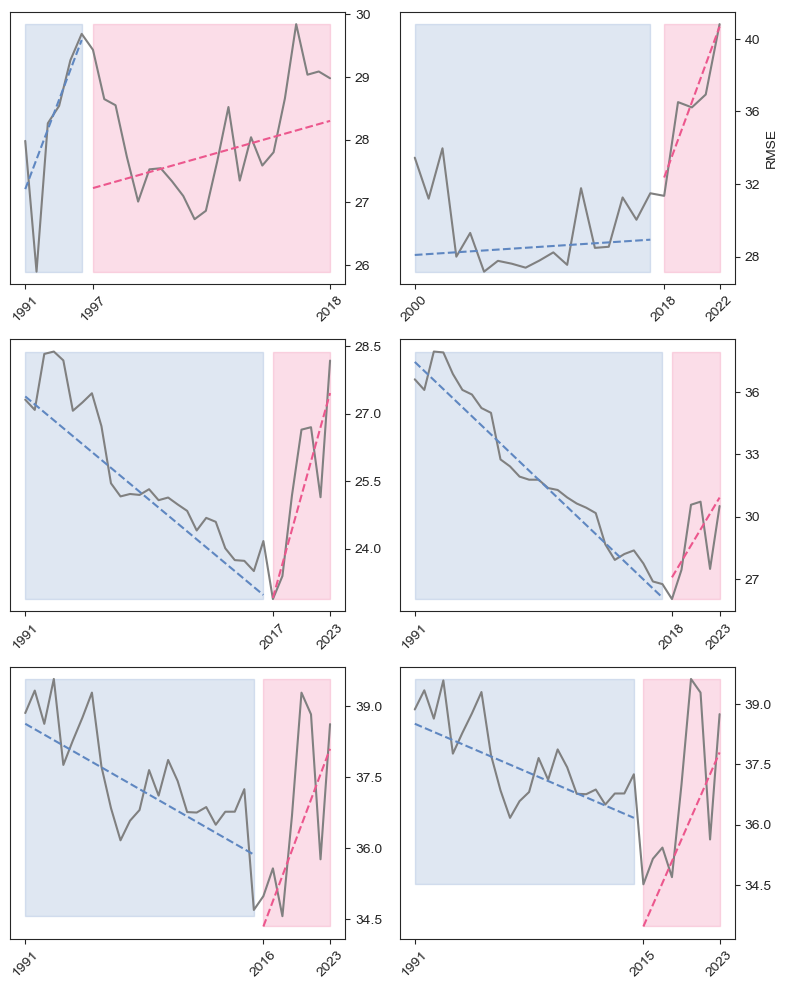

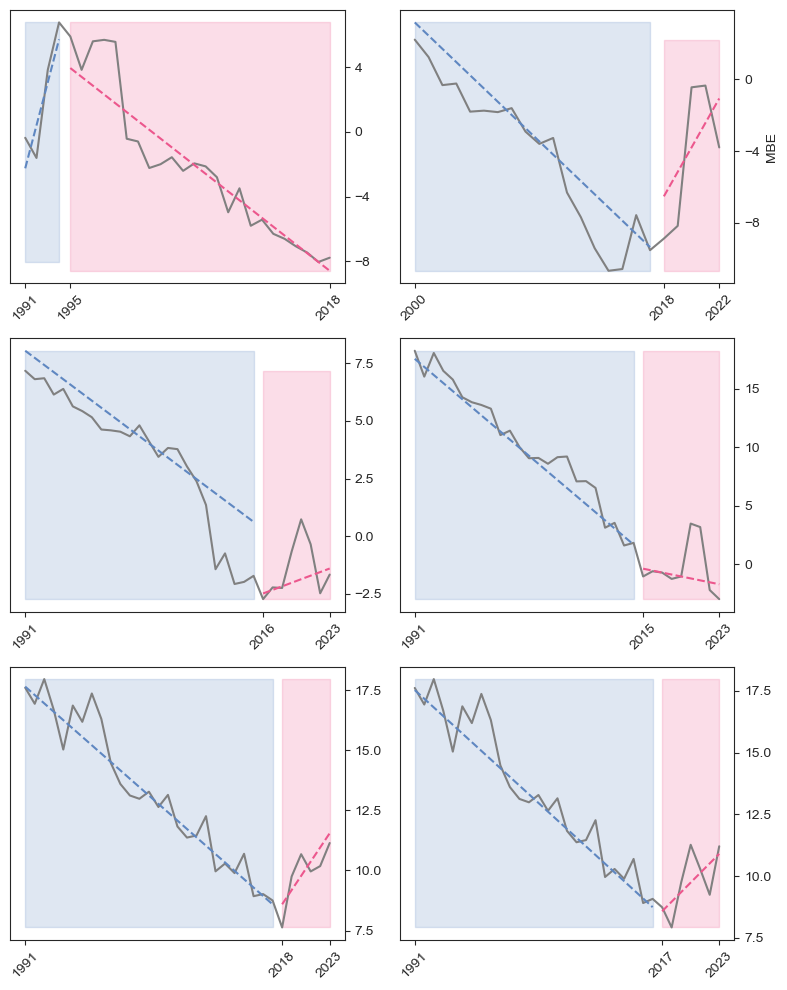

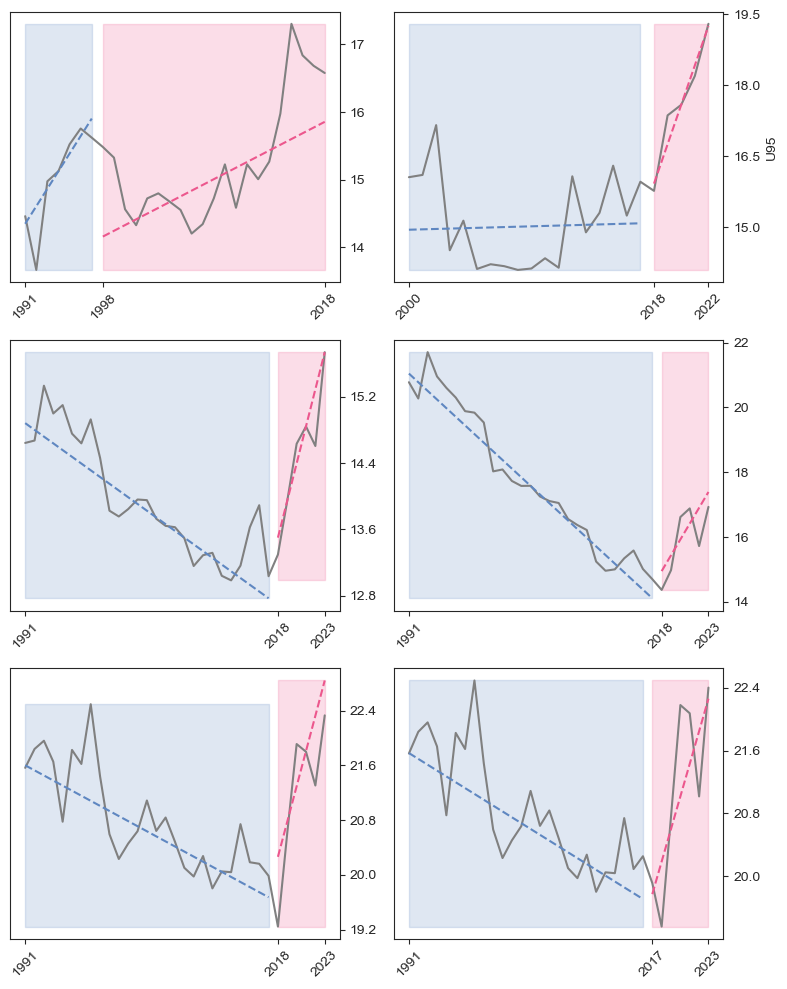

In [24]:
# 假设以下变量已定义
products_name = ['ISCCP', 'GLASS', 'ERA5', 'MERRA-2', 'SSP245', 'SSP585']
metrics = ["R", "RMSE", "MBE", "U95"]


# 定义一个函数来计算最佳分割点，并确保每段至少有5个年份
def find_best_segment_point(error_series, min_segment_length=5):
    best_slope_sum = -np.inf
    best_point = len(error_series) // 2  # 初始值

    # 检查数据长度是否满足分割条件
    total_length = len(error_series)
    if total_length < 2 * min_segment_length:
        # 数据长度不足，无法分割，返回中点
        return best_point

    # 计算可能的分割点范围
    min_split = min_segment_length - 1
    max_split = total_length - min_segment_length

    # 遍历可能的分割点
    for split_point in range(min_split, max_split + 1):
        first_segment = error_series[:split_point]
        second_segment = error_series[split_point:]

        # 计算两段的 Sen 斜率
        first_result = mk.original_test(first_segment)
        second_result = mk.original_test(second_segment)

        # 计算斜率之和
        slope_sum = first_result.slope + second_result.slope

        # 选择斜率之和最大的分割点
        if slope_sum > best_slope_sum:
            best_slope_sum = slope_sum
            best_point = split_point

    return best_point

# 遍历要计算的误差
for metric in metrics:
    fig, axs = plt.subplots(3, 2, figsize=(8, 10))
    axs = axs.flatten()

    for ax_idx, (model, product_name) in enumerate(zip(models_y, products_name)):
        if ax_idx >= len(axs):
            break  # 超出子图数量时跳过

        ax = axs[ax_idx]

        # 按年分组计算误差的时间序列
        errorByMonth = model.groupby("date").apply(lambda x: calculate_error(x['Observation'], x['Model'], metric), include_groups=False).reset_index()

        # 动态寻找最佳分割点，确保每段至少有5个年份
        best_split_point = find_best_segment_point(errorByMonth[0])

        # 第一段数据
        first_segment = errorByMonth[0][:best_split_point]
        first_result = mk.original_test(first_segment)
        first_sen_slope = first_result.slope
        first_mk_p_value = first_result.p
        first_intercept = first_result.intercept

        # 第二段数据
        second_segment = errorByMonth[0][best_split_point:]
        second_result = mk.original_test(second_segment)
        second_sen_slope = second_result.slope
        second_mk_p_value = second_result.p
        second_intercept = second_result.intercept

        # 计算趋势线
        first_x = np.arange(len(first_segment))
        first_trend_line = first_sen_slope * first_x + first_intercept

        second_x = np.arange(len(second_segment))
        second_trend_line = second_sen_slope * second_x + second_intercept

        # 绘图
        ax.plot(errorByMonth["date"], errorByMonth[0], label=product_name, color="grey", zorder=10)
        ax.plot(errorByMonth["date"][:best_split_point], first_trend_line, label='First Segment Trend Line', linestyle='--', color='#5f87c1', zorder=11)
        ax.plot(errorByMonth["date"][best_split_point:], second_trend_line, label='Second Segment Trend Line', linestyle='--', color='#ec578d', zorder=11)

        # 填充区域
        ax.fill_between(errorByMonth["date"][:best_split_point], min(errorByMonth[0].min(), first_trend_line.min()), max(errorByMonth[0].max(), first_trend_line.max()), color='#5f87c1', alpha=0.2, zorder=9)
        ax.fill_between(errorByMonth["date"][best_split_point:], min(errorByMonth[0].min(), second_trend_line.min()), max(errorByMonth[0].max(), second_trend_line.max()), color='#ec578d', alpha=0.2, zorder=9)

        # 添加标签
        # ax.text(0.02, -0.1, f'First Sen Slope: {first_sen_slope:.3f}, p-value: {get_star_string(first_mk_p_value)}', transform=ax.transAxes)
        # ax.text(0.02, -0.2, f'Second Sen Slope: {second_sen_slope:.3f}, p-value: {get_star_string(second_mk_p_value)}', transform=ax.transAxes)

        # 设置轴刻度和标签
        first_date = errorByMonth["date"].iloc[0]
        mid_date = errorByMonth["date"].iloc[best_split_point]
        last_date = errorByMonth["date"].iloc[-1]
        ax.set_xticks([first_date, mid_date, last_date])
        ax.set_xticklabels([first_date, mid_date, last_date], rotation=45)

        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")

        if product_name == "GLASS":
            ax.set_ylabel(metric)

    # 调整布局
    plt.subplots_adjust(hspace=0.5)
    plt.tight_layout()
    plt.show()

### 计算每个产品的各个评价指标在站点尺度的MK的斜率，绘制15，转Arcgis绘图（年分组）

In [191]:
# 读取数据库
database = pd.read_feather(r"D:\PhD\data\station_feather\station_data_all_v3.feather").rename(columns={'daily_radiation':'Observation', "MERRA2":"MERRA-2", "ISCCP-ITP":"ISCCP"})
database["originalID"] = database["originalID"].astype(str)
database["year"] = database["date"].apply(lambda x: x.year)
# 读取站点数据
station = pd.read_excel(r"D:\PhD\data\station_all_v3.xlsx")[["originalID", "lat", "lon"]]
station["originalID"] = station["originalID"].astype(str)

# 逐日数据，但有year字段
database_ISCCP_d  = database[~database['ISCCP'].isna()][['originalID', "year", 'Observation','ISCCP']].rename(columns={'ISCCP':'Model'}).reset_index(drop=True)
database_GLASS_d  = database[~database['GLASS'].isna()][['originalID', "year", 'Observation','GLASS']].rename(columns={'GLASS':'Model'}).reset_index(drop=True)
database_ERA5_d  = database[~database['ERA5'].isna()][['originalID', "year", 'Observation','ERA5']].rename(columns={'ERA5':'Model'}).reset_index(drop=True)
database_MERRA2_d = database[['originalID', "year", 'Observation','MERRA-2']].rename(columns={'MERRA-2':'Model'}).reset_index(drop=True)
database_SSP245_d = database[~database['SSP245'].isna()][['originalID', "year", 'Observation','SSP245']].rename(columns={'SSP245':'Model'}).reset_index(drop=True)
database_SSP585_d = database[~database['SSP585'].isna()][['originalID', "year", 'Observation','SSP585']].rename(columns={'SSP585':'Model'}).reset_index(drop=True)

productions = [database_ISCCP_d, database_GLASS_d, database_ERA5_d, database_MERRA2_d, database_SSP245_d, database_SSP585_d]
metrics = ["R", "RMSE", "MBE", "U95"] # 定义要分析的指标列
products_name = ['ISCCP', 'GLASS', 'ERA5', 'MERRA2', 'SSP245', 'SSP585'] # 产品名，用于excel命名

In [192]:
for production, product_name in zip(productions, products_name):
    # 计算某个产品的各个站点在每年的指标
    error_dict = (production.groupby(["originalID", "year"]).filter(lambda x: len(x) > 1).groupby(["originalID", "year"]).apply(lambda x: calculate_error(x['Observation'], x['Model']), include_groups=False))
    # 将字典转换为 DataFrame
    error = pd.DataFrame(error_dict.tolist(), index=error_dict.index)

    # 初始化一个空的 DataFrame 来存储结果
    results = pd.DataFrame(columns=['originalID', 'variable', 'slope', 'trend'])
    # 按 originalID 分组
    for original_id, group in error.groupby(level='originalID'):
        for metric in metrics:
            # 检查数据点数量是否足够
            if len(group[metric]) < 2:
                continue  # 数据点不足，跳过本次循环

            # 进行 MK 趋势分析
            result = mk.original_test(group[metric])

            # 提取斜率和趋势值
            slope = result.slope
            trend = result.trend

            # 将结果添加到结果 DataFrame 中
            new_row = pd.DataFrame({
                'originalID': [original_id],
                'variable': [metric],
                'slope': [slope],
                'trend': [trend]
            })
            results = pd.concat([results, new_row], ignore_index=True)

    # 进行数据透视，以 originalID 为行索引，variable 为列索引，slope 为值
    final_results = results.pivot(index='originalID', columns='variable', values='slope').reset_index()
    # 重命名列名，去掉多余的索引层级
    final_results.columns.name = None
    # 添加坐标
    final_results = pd.merge(final_results, station, on="originalID", how="left")
    # 保存为excel
    final_results.to_excel(fr"D:\PhD\UCAS\Undergraduate\Projects\Python\datas\14MK_{product_name}.xlsx")

In [193]:
# 读取各excel，用于计算arcgis分级色彩的范围
for production, product_name in zip(productions, products_name):
    print("\n\n**********************************当前数据产品：", product_name)
    MK_data = pd.read_excel(fr"D:\PhD\UCAS\Undergraduate\Projects\Python\datas\14MK_{product_name}.xlsx")
    for metric in metrics:
        print("\n*******************************指标：", metric)
        MK_data["group"], bins = pd.qcut(MK_data[metric], 4, retbins=True, duplicates="drop")

        # 计算每个组中的记录数
        group_counts = MK_data['group'].value_counts().sort_index()
        # 输出每个组中的记录数
        for group, count in group_counts.items():
            print(f"组 {group}: {count} 条记录")




**********************************当前数据产品： ISCCP

*******************************指标： R
组 (-0.076, -0.000735]: 114 条记录
组 (-0.000735, 0.0]: 113 条记录
组 (0.0, 0.00125]: 114 条记录
组 (0.00125, 0.19]: 112 条记录

*******************************指标： RMSE
组 (-13.033, -0.391]: 114 条记录
组 (-0.391, -0.0731]: 113 条记录
组 (-0.0731, 0.286]: 113 条记录
组 (0.286, 8.356]: 113 条记录

*******************************指标： MBE
组 (-13.914, -0.945]: 114 条记录
组 (-0.945, -0.264]: 113 条记录
组 (-0.264, 0.286]: 113 条记录
组 (0.286, 11.63]: 113 条记录

*******************************指标： U95
组 (-12.211, -0.261]: 114 条记录
组 (-0.261, -0.0522]: 113 条记录
组 (-0.0522, 0.2]: 113 条记录
组 (0.2, 4.222]: 113 条记录


**********************************当前数据产品： GLASS

*******************************指标： R
组 (-0.144, -0.000534]: 124 条记录
组 (-0.000534, 0.000746]: 124 条记录
组 (0.000746, 0.003]: 133 条记录
组 (0.003, 0.672]: 115 条记录

*******************************指标： RMSE
组 (-19.993000000000002, -0.866]: 124 条记录
组 (-0.866, -0.184]: 124 条记录
组 (-0.184, 0.337]: 124 条记录
组 (0.